In [7]:
### Importer les modules ###
import os
import glob
import scipy
import pylab
import tables
import pyphot
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fftpack import fft, fftshift


http://www.astro.caltech.edu/sedm/Efficiency.html
### Définir les constantes ###
h = 6.62606885e-27  #erg s
hc = 1.98782e-8  #erg A

### Les paramètres données ###
A_tel = 18  #cm^2, area of the primary mirror accounting for the secondary obstruction
A_tel_eff = 14.742  # = A_tel*0.91*0.9, reflectivity 91% for the primary and 90% for the secondary

# Optical Design Info
R ~ 4500, with a 1" slit
350 - 2000nm band

## UV-VIS
Collimator Focal Ratio = 6.5 <br>
COllimator Beam diameter = 45 mm <br>
Spectral range = 350-850 nm <br>
Resolution (1 arcsec slit) = 3500-7000 <br>
Slit scale = 110 μm/" <br>
Foreseen slit widths = 0.5" − 1.0" − 1.5" − 5" <br>
Slit height = 12" <br>
Camera Output Focal Ratio = 3.11 <br>
Detector = Teledyne e2V CCD44-82 <br>
Detector Scale = ∼ 53 μm/" <br>
Main Disperser = Four custom ion etched gratings <br>
Working temperature = Ambient (-5°C − +25°C) <br>






In [9]:
### Average resolution ###
R_u = 4995
R_g = 4634
R_r = 4633
R_i = 4601
# sigma
dR_u = 1059
dR_g = 890
dR_r = 909
dR_i = 878

# delta lambda - limit of resolution = lambda/R

N_pas = 100000

### wavelength range ### (nm)
u = np.linspace(350.0,440.0,N_pas)
g = np.linspace(427.0,545.0,N_pas)
r = np.linspace(522.0,680.0,N_pas)
i = np.linspace(656.0,850.0,N_pas)

### Throughput ###
# Total expected
Thr_u = 0.741
Thr_g = 0.737
Thr_r = 0.749
Thr_i = 0.726
# w/ contingency at 2% to all estimates
thr_u = 0.643
thr_g = 0.627
thr_r = 0.663
thr_i = 0.630

# Line Density (lines/mm) -> (lines/nm)
ld_u = 3380*10**-6
ld_g = 2655*10**-6
ld_r = 2070*10**-6
ld_i = 1660*10**-6

# Line Spacing d = Line Density ^-1
d_u = ld_u**-1
d_g = ld_g**-1
d_r = ld_r**-1
d_i = ld_i**-1

# Feed Angle
alpha = 41*np.pi/180. # ◦ -> rad 

# lambda Littrow (nm)
ll_u = 388.2
ll_g = 494.2
ll_r = 633.9
ll_i = 790.4

# pixel (m) detector 2k x 4k
pix_x = 15*10**-6
pix_y = 15*10**-6

# UV-VIS should be able to switch between different slit size [arcsec]:
slit = [0.5,1.0,1.5,5.0]

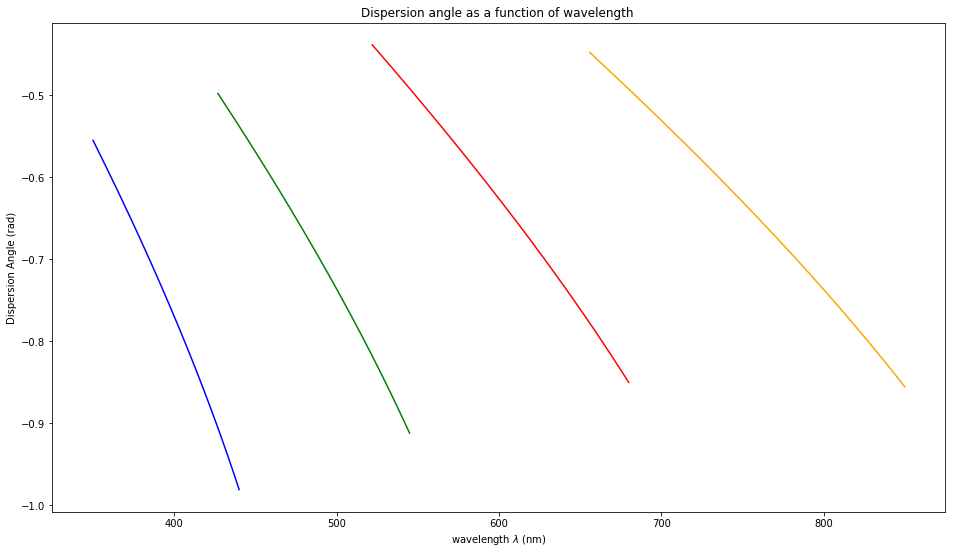

In [10]:
# Dispersion Angle (m=1)
da_u = np.arcsin(np.sin(alpha) - u*ld_u)
da_g = np.arcsin(np.sin(alpha) - g*ld_g)
da_r = np.arcsin(np.sin(alpha) - r*ld_r)
da_i = np.arcsin(np.sin(alpha) - i*ld_i)
plt.figure(figsize=[16,9])
plt.title("Dispersion angle as a function of wavelength ")
plt.xlabel("wavelength $\lambda$ (nm)")
plt.ylabel("Dispersion Angle (rad)")
plt.plot(u,da_u,'b')
plt.plot(g,da_g,'g')
plt.plot(r,da_r,'r')
plt.plot(i,da_i,'orange')

In [ ]:
# seeing

# throughput
throughput (w/ contingency at 2% to all estimates)

if wav in u:
    amp = amp * thr_u
if wav in g:
    amp = amp * thr_g
if wav in r:
    amp = amp * thr_r
if wav in i:
    amp = amp * thr_i

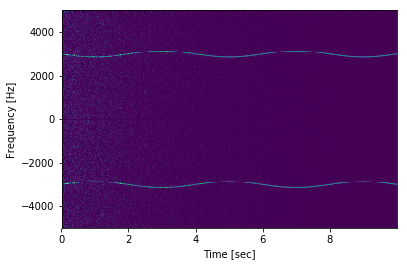

In [4]:
# Compute a spectrogram with consecutive Fourier transforms. Spectrograms can be used as a way of visualizing 
# the change of a nonstationary signal’s frequency content over time.
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise
f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx)
f, t, Sxx = signal.spectrogram(x, fs, return_onesided=False)
plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

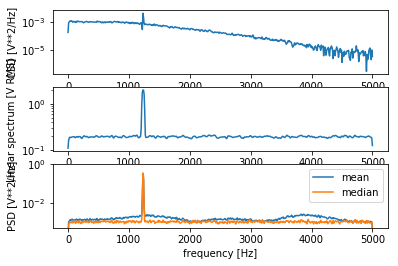

In [112]:
# Estimate the cross power spectral density, Pxy, using Welch’s method.
# Generate two test signals with some common features.
fs = 10e3
N = 1e5
amp = 20
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
b, a = signal.butter(2, 0.25, 'low')
x = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
y = signal.lfilter(b, a, x)
x += amp*np.sin(2*np.pi*freq*time)
y += np.random.normal(scale=0.1*np.sqrt(noise_power), size=time.shape)
#Compute and plot the magnitude of the cross spectral density.
f, Pxy = signal.csd(x, y, fs, nperseg=1024)
plt.figure()
plt.subplot(311)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
# Estimate power spectral density using Welch’s method.
# Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping 
# segments, computing a modified periodogram for each segment and averaging the periodograms.
np.random.seed(1234)
#Generate a test signal, a 2 Vrms sine wave at 1234 Hz, corrupted by 0.001 V**2/Hz of white noise sampled at 10 kHz.
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# Compute and plot the power spectral density.
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.subplot(312)
#plt.semilogy(f, Pxx_den)
plt.semilogy(f, np.sqrt(Pxx_spec))
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
#plt.ylabel('PSD [V**2/Hz]')
# If we now introduce a discontinuity in the signal, by increasing the amplitude of a small portion of the signal 
# by 50, we can see the corruption of the mean average power spectral density, but using a median average better 
# estimates the normal behaviour.
plt.subplot(313)
x[int(N//2):int(N//2)+10] *= 50.
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
f_med, Pxx_den_med = signal.welch(x, fs, nperseg=1024, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

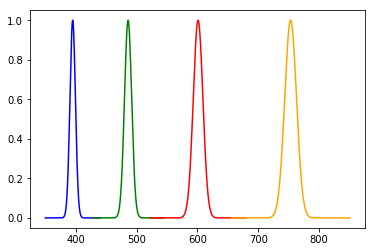

In [54]:
# Générer un signal gaussian
# M = np.size(u)+np.size(g)+np.size(r)+np.size(i)
# x = np.linspace(350.0,850.0,M)
Gauss = signal.gaussian(N_pas, std=5000, sym=False)
plt.plot(u,Gauss,'b')
plt.plot(g,Gauss,'g')
plt.plot(r,Gauss,'r')
plt.plot(i,Gauss,'orange')
plt.show()

/home/jinlng/test_dir/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


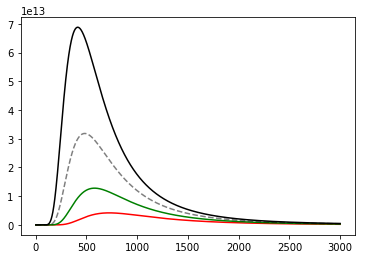

In [81]:
# Basic black-body spectrum plot
h = 6.62606885e-34 # Planck constant
c = 2.99792458e+8  # speed of light
k = 1.38064852e-23 # Boltzmann constant

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
wavelengths = np.arange(1e-9, 3e-6, 1e-9) 

# intensity at 4000K, 5000K, 6000K, 7000K
intensity4000 = planck(wavelengths, 4000.)
intensity5000 = planck(wavelengths, 5000.)
intensity6000 = planck(wavelengths, 6000.)
intensity7000 = planck(wavelengths, 7000.)

plt.plot(wavelengths*1e9, intensity4000, 'r-') 
#plot intensity4000 versus wavelength in nm as a red line
plt.plot(wavelengths*1e9, intensity5000, 'g-') # 5000K green line
plt.plot(wavelengths*1e9, intensity6000, 'k--',alpha=0.5) # 6000K blue line
plt.plot(wavelengths*1e9, intensity7000, 'k-') # 7000K black line

# show the plot
plt.show()

In [30]:
from astropy.modeling import models
from astropy import units as u
bb = models.BlackBody1D()
bb(6000 * u.AA)

<Quantity 1.35853786e-15 erg / (cm2 Hz s)>

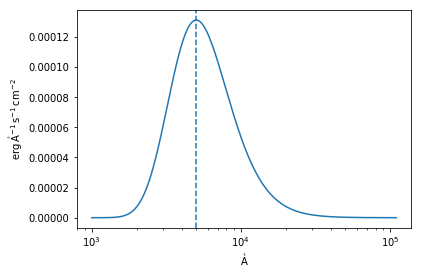

In [78]:
from astropy.modeling.models import BlackBody1D
from astropy.modeling.blackbody import FLAM
from astropy import units as u
from astropy.visualization import quantity_support

bb = BlackBody1D(temperature=5778*u.K)
wav = np.arange(1000, 110000) * u.AA
flux = bb(wav).to(FLAM, u.spectral_density(wav))



with quantity_support():
    plt.figure()
    plt.semilogx(wav, flux)
    plt.axvline(bb.lambda_max.to(u.AA).value, ls='--')
    plt.show()

In [89]:
### Spectral Lines ###
# lambda_obs = (1+z)*lambda
# Emission Lines
O4 = 1033.82 
ly_alpha = 1215.67
N5 = 1240.81
O1 = [1305.53,6302.046,6365.536]
C2 = 1335.31
Si4 = 1397.61
Si4_plus_O4 = 1399.8
C4 = 1549.48
He2 = 1640.4
O3 = [1665.85,4364.436,4932.603,4960.295,5008.240]
Al3 = 1857.4
C3 = 1908.734
C2 = 2326.0
Ne4 = 2439.5
Mg2 = 2799.117
Ne5 = 3346.79
Ne6 = 3426.85
O2 = [3727.092,3729.875]
He1 = 3889.0
S2 = [4072.3,6718.29,6732.67]
H_delta = 4102.89
H_gamma = 4341.68
H_beta = 4862.68

N1 = 6529.03
N2 = [6549.86,6585.27]
H_alpha = 6564.61

O = [O4] + O1 + O2 + O3
O.sort()

C = [C2,C4,C3,C2]

H = [H_delta,H_gamma,H_beta,H_alpha]

# Absorption Lines
ab_K = 3934.777
ab_H = 3969.588
ab_G = 4305.61
ab_Mg = 5167.7
ab_Na = 5895.6
ab_Ca2 = [8500.36,8544.44,8664.52]

# Sky Lines
Sky = [5578.5,5894.6,6301.7,7246.0]


In [ ]:
# H emission lines (Gaussian)


### slow af, don't use this:
from random import gauss
mean = (850+350)*0.5
stdDev = 500
Gauss_1 = [gauss(mean,stdDev) for i in range(M)]
n, bins, patches = plt.hist(Gauss_1, M, facecolor='green', alpha=0.5)
#plt.plot(x,Gauss_1)
plt.show()

In [ ]:
# Read and save ascii files
input_data = ascii.read(".ascii")



In [1]:
# binning code from Rachel
lamda = 
lamda_1st = lamda[0]
lamda_last = lamda[-1]
def bin_spectra(spectrum, resolution):
    n_bin = math.floor((lamda_last - lamda_1st)/resolution)
    
    #performs the data rebinning by taking the beam of the fluc value inside the bin
    stat, bin_edge, inde = scipy.stats.binned_statistic(lamda, flux_unred, statistic='mean', 
                                                        bins = n_bin)
    
    
    bin_wavelength = [ (bin_edge[i]+ bin_edge[i+1])/2 for i in range(len(bin_edge)-1) ]
    bin_spectra = Table()
    bin_spectra['bin_wl'] = bin_wavelength
    bin_spectra['bin_unred_flux'] = stat
    
    return bin_spectra

SyntaxError: invalid syntax (<ipython-input-1-25a4e8328355>, line 2)

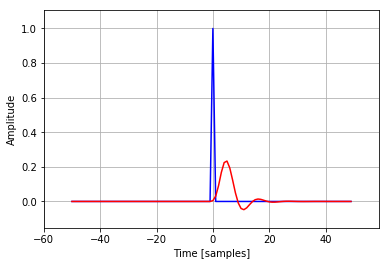

In [30]:
# Unit impulse signal (discrete delta function) or unit basis vector.
signal.unit_impulse((4, 4), 2)
imp = signal.unit_impulse(100,'mid')
b, a = signal.butter(4, 0.2)
response = signal.lfilter(b, a, imp)
import matplotlib.pyplot as plt
plt.plot(np.arange(-50, 50), imp, 'b')
plt.plot(np.arange(-50, 50), response, 'r')
plt.margins(0.1, 0.1)
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
delta = signal.unit_impulse((4, 4), 2)
f = delta(100,'mid') + delta()

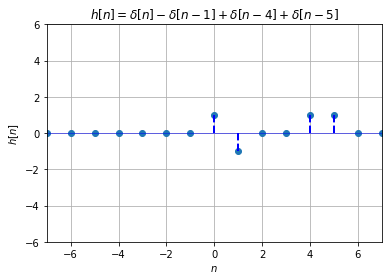

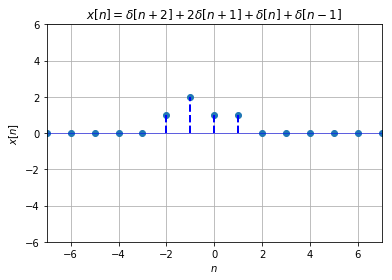

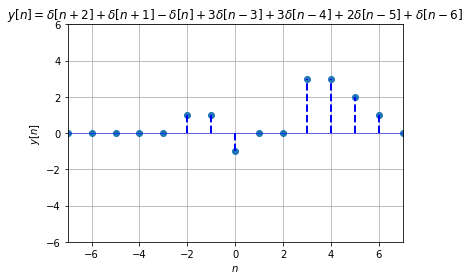

In [17]:
import numpy as np
import matplotlib.pyplot as plt

#Defining the delta function
def delta(n):
    if n == 0:
        return 1
    else:
        return 0

h_ = []
x_ = []
y_ = []
n = 7

#Writing the h[n] function in terms of delta function
for i in range(-n,n+1):
    h = delta(i) - delta(i-1) + delta(i-4) + delta(i-5)
    h_.append(h)

#Writing the x[n] function in terms of delta function
for i in range(-n,n+1):
    x = delta(i-1) + delta(i) + 2*delta(i+1) + delta(i+2)
    x_.append(x)

#Linearly Convolving the two functions
y_ = np.convolve(x_,h_,mode='full')

#Plotting the h[n] function
plt.figure(1)
markerline, stemlines, baseline = plt.stem(range(-n,n+1),h_, '--')
plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)
plt.ylim([-6,6])
plt.xlim([-n,n])
plt.xlabel('$n$')
plt.ylabel('$h[n]$')
plt.title('$h[n] = \delta [n] - \delta [n-1] + \delta [n-4] + \delta [n-5] $')
plt.grid(True)

#Plotting the x[n] function
plt.figure(2)
markerline, stemlines, baseline = plt.stem(range(-n,n+1),x_, '--')
plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)
plt.ylim([-6,6])
plt.xlim([-n,n])
plt.xlabel('$n$')
plt.ylabel('$x[n]$')
plt.title('$x[n] = \delta [n+2] + 2\delta [n+1] + \delta [n] + \delta [n-1]$')
plt.grid(True)

#Plotting the y[n] function
plt.figure(3)
markerline, stemlines, baseline = plt.stem(range(-2*n,2*n+1),y_, '--')
plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)
plt.ylim([-6,6])
plt.xlim([-n,n])
plt.xlabel('$n$')
plt.ylabel('$y[n]$')
plt.title('$y[n] = \delta [n+2] + \delta [n+1] -\delta [n] + 3\delta [n-3] + 3\delta [n-4] + 2\delta [n-5] + \delta [n-6] $')
plt.grid(True)

plt.show()

In [ ]:
sympy.functions.special.delta_functions

In [31]:
Collimateur_EFL = 272.55 # mm
Collimateur_RFL = 292.12 # mm, reflected focal length
Camera_FL = 140 # mm, camera's focal length
# Dispersion Angle (m=1)
# to make things easier, start with Onde monochromatique
lamda_mono = 5000*1e-10 # Å -> m
ld_g = 2655*1e3 #(lines/mm) -> (lines/m)
alpha = 41*np.pi/180. # ◦ -> rad, Feed Angle
dis_ang = np.arcsin(np.sin(alpha) - lamda_mono*ld_g) # 5000 Å is inside g's range
resp_spec = Collimateur_RFL*dis_ang  # spectral response
resp_spec_g = Collimateur_RFL*da_g

In [32]:
 def unit_circle(r):
    d = 2*r + 1
    rx, ry = d/2, d/2
    x, y = np.indices((d, d))
    return (np.abs(np.hypot(rx - x, ry - y)-r) < 0.5).astype(int)

In [33]:
from sympy import DiracDelta, cos
from sympy.abc import x, y
import poppy
import numpy as np

In [35]:
aperture = unit_circle(6)
psf = np.fft.fft2(aperture)
np.convolve(psf,resp_spec_g)

ValueError: object too deep for desired array

In [38]:
print (type(psf),np.size(psf))
print (type(resp_spec_g), np.size(resp_spec_g))

<class 'numpy.ndarray'> 169
<class 'numpy.ndarray'> 100000


99


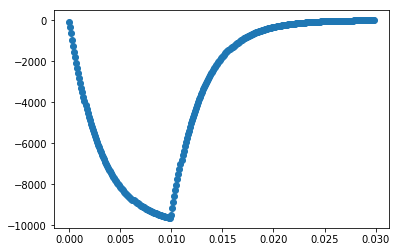

In [7]:
import numpy as np
import matplotlib.pyplot as plt
R = 1e3 
L = 3. 

delta = 1
Nf = 100
Nw = 200
k = np.arange(0,Nw,delta)
dt = 0.1e-3 
tk = k*dt
Ng = Nf + Nw -2
n = np.arange(0,Nf+Nw-1,delta)
tn = n*dt

#define H
def H(n):
    H = np.ones(n)
    H[0] = 0.5
    return H

#build ftns that get convoluted
f = H(Nf)
w = np.exp((-R/L)*tk)*H(Nw)

#return the value of I
It = np.convolve(w,f)/L
max_ind = np.argmax(It)
print (max_ind)
It1 = It[max_ind:]

#return the value of Voutput, b(t)
b = H(Ng+1) - R*It
plt.plot(tn,b,'o')
plt.show()

100 100


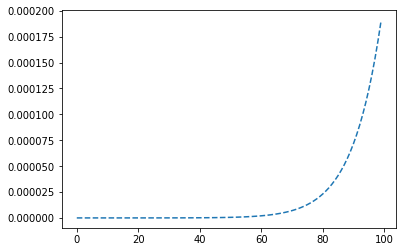

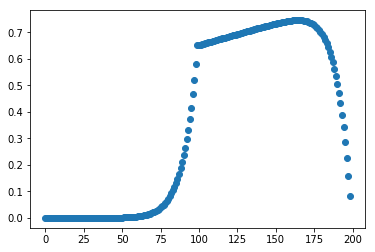

In [16]:
def planck(wav_aa, T):
    wav = wav_aa * 1e-10
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def fct_Gauss(x,esp,var):
    return ((1./np.sqrt(var*2*np.pi))*np.exp(-0.5*(x-esp)**2/var))


# Emission Lines
O4 = 1033.82 
ly_alpha = 1215.67
N5 = 1240.81
O1 = [1305.53,6302.046,6365.536]
C2 = 1335.31
Si4 = 1397.61
Si4_plus_O4 = 1399.8
C4 = 1549.48
He2 = 1640.4
O3 = [1665.85,4364.436,4932.603,4960.295,5008.240]
Al3 = 1857.4
C3 = 1908.734
C2 = 2326.0
Ne4 = 2439.5
Mg2 = 2799.117
Ne5 = 3346.79
Ne6 = 3426.85
O2 = [3727.092,3729.875]
He1 = 3889.0
S2 = [4072.3,6718.29,6732.67]
H_delta = 4102.89
H_gamma = 4341.68
H_beta = 4862.68

N1 = 6529.03
N2 = [6549.86,6585.27]
H_alpha = 6564.61

O = [O4] + O1 + O2 + O3
O.sort()

C = [C2,C4,C3,C2]

H = [H_delta,H_gamma,H_beta,H_alpha]


T_sol = 5778 # Sun

h = 6.62606885e-34 # Planck constant
c = 2.99792458e+8  # speed of light
k = 1.38064852e-23 # Boltzmann constant
N_pas = 100
domaine = np.linspace(350.0,440.0,N_pas)
signal = planck(domaine,T_sol)
amp = np.max(signal)*np.random.rand(len(H))
amp.sort()
for i in range(len(H)):
    signal += fct_Gauss(domaine,H[i],1)*amp[i]*0.5
    
Sig_out = np.convolve(signal,domaine)
    
print (len(signal),len(domaine))

#return the value of Voutput, b(t)
plt.figure(211)
plt.plot(signal,'--')
plt.figure(212)
plt.plot(Sig_out,'o')
plt.show()

In [34]:
# from itertools import product
# for md, pico in product(range(1,5), range(25)):
#     print ("file-{0}-loop-{1}".format(md, pico))

In [35]:
from sympy import *
init_printing()
lam,lam0,sig,a,b = symbols('lambda,lambda_0,sigma,a,b')
exp(-(lam-lam0)**2/2/(a*lam+b))
exp(-(lam-lam0)**2/2/(a*lam0+b))

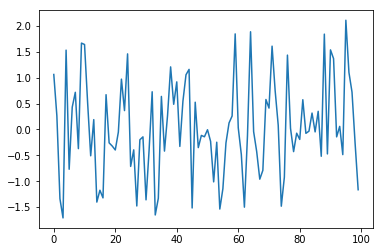

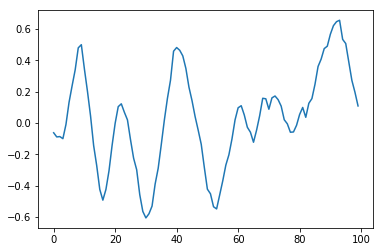

In [38]:
from scipy.integrate import quad
#Gaussian kernel (not normalized here)
def gaussian(x, sigma):
    return np.exp(-(x/sigma)**2/2) 

#convolution
def smooth(y,box_pts): 
    x = (np.linspace(-box_pts/2.,box_pts/2.,box_pts + 1)) #Gaussian centred on 0
    std_norm = 3. #3. is an arbitrary value for normalizing the sigma
    sigma = box_pts/std_norm 
    integral = quad(gaussian, x[0], x[-1], args=(sigma))[0]
    box = gaussian(x, sigma)/integral
    y_smooth = np.convolve(y,box,mode='same')
    return y_smooth

box_size = 10
length = 100
y = np.random.randn(length)
y_smooth = smooth(y,box_size)
plt.plot(y)
plt.show()
plt.plot(y_smooth)
plt.show()

In [1]:
# let's try some lambdas first
sample1 = int(n*0.9)
sample2 = int(n*0.3)
sample3 = int(n*0.6)

dlam1 = wavelength[sample1]/R[sample1]
sigma1 = dlam1 / np.sqrt(8*np.log(2))
fv1 = fct_Gauss(wavelength,wavelength[sample1],sigma1**2)
fo1 = np.convolve(fi,fv1,mode='same')

dlam2 = wavelength[sample2]/R[sample2]
sigma2 = dlam2 / np.sqrt(8*np.log(2))
fv2 = fct_Gauss(wavelength,wavelength[sample2],sigma2**2)
fo2 = np.convolve(fi,fv2,mode='same')

dlam3 = wavelength[sample3]/R[sample3]
sigma3 = dlam3 / np.sqrt(8*np.log(2))
fv3 = fct_Gauss(wavelength,wavelength[sample3],sigma3**2)
fo3 = np.convolve(fi,fv3,mode='same')
plt.figure(figsize=[10,5])
plt.plot(wavelength,fo1,label='$\lambda_1$',alpha = 0.7)
plt.plot(wavelength,fo2,label='$\lambda_2$',alpha = 0.7)
plt.plot(wavelength,fo3,label='$\lambda_3$',alpha = 0.7)
#plt.plot(wavelength,fo1+fo2+fo3,label='sum',alpha = 0.7,linestyle='-.')
plt.legend()
plt.grid(True)
plt.show()

start = time. time()
res_conv = np.zeros(n)
for i in range(n):
    dLam = wavelength[i]/R[i] # == FHWM
    sigma = dLam / np.sqrt(8*np.log(2)) # FHWM = np.sqrt(8*np.log(2)) * sigma
    fv = fct_Gauss(wavelength,wavelength[i],sigma**2)
    res_conv += np.convolve(fi,fv,mode='same')
    
plt.figure(figsize=[10,5])
plt.plot(wavelength,res_conv,label='test with built-in module')
plt.legend()
plt.grid(True)
plt.show()

end = time. time()
print('Time used:',end - start)

print(np.trapz(fi,wavelength))
print(np.trapz(fo1,wavelength))
print(np.trapz(fo2,wavelength))
print(np.trapz(fo3,wavelength))
print(np.trapz(fv1,wavelength))
print(np.trapz(fv2,wavelength))
print(np.trapz(fv3,wavelength))

print(np.trapz(res_conv,wavelength))

# find the index of all minimums
x_min_loc = signal.argrelmin(fo_module)[0]
x_min_loc = x_min_loc[1:-1]
print ('minimum local located at:',x_min_loc)
# find the values of these minimums
f_min_loc = []
for i in x_min_loc:
    f_min_loc.append(fo_module[i])
print ('value of minimums:',f_min_loc)

# find the index of all the peaks
x_peaks = signal.find_peaks(fo_module)[0]
x_peaks = x_peaks[1:-2]
print ('peaks located at:',x_peaks)
# values corresponding to these peaks
f_peaks = []
for i in x_peaks:
    f_peaks.append(fo_module[i])
print ('value of peaks:',f_peaks)

# contrast : max_max and min_loc_min even though they aren't next to each other ???
contrast = (np.max(fo_module) - fo_module[38834]) / (np.max(fo_module) + fo_module[38834])
print ('contrast =', contrast)

# or : find each max_loc as well, calculate every contrast and compare ???
contrast_all = []
for i in range(len(x_peaks)):
    contrast_all.append((f_peaks[i] - f_min_loc[i]) / (f_peaks[i] + f_min_loc[i]))
print (contrast_all)
# remark: the first peak has a contrast slightly lower than 15% 

# print(fo_module[16610],fo_module[27723],fo_module[38834],fo_module[49945],
#       fo_module[61056],fo_module[72129],fo_module[83280])
# print(np.max([fo_module[16610],fo_module[27723],fo_module[38834],fo_module[49945],
#       fo_module[61056],fo_module[72129],fo_module[83280]]))

### wavelength range ### (nm)
N_pas = 1000
u = np.linspace(350.0,440.0,N_pas)
g = np.linspace(427.0,545.0,N_pas)
r = np.linspace(522.0,680.0,N_pas)
i = np.linspace(656.0,850.0,N_pas)
wavelength = np.linspace(350,850,N_pas*4)

wavelength = np.linspace(350,500,n)
R = np.linspace(4000,5000,n)
# plt.xlabel("wavelength(nm)",fontsize=20)
# plt.ylabel(r'$\frac{\lambda}{\delta \lambda}$',fontsize=20)
# plt.plot(wavelength,R)
# dLam = wavelength/R 
# plt.title(r'$\delta \lambda$')
# plt.plot(wavelength,dLam)
# # remark: non linear

NameError: name 'n' is not defined

In [ ]:
n = 10000 
# input signal
f = np.random.randn(n)
# find the sigma of input signal

sig_in = 0. #FWHM / np.sqrt(8*np.log(2))
# try first with R=cste
R = 5000

######################################
dLam = wavelength/R   # dλ define the h(x) 
sig_g = dLam / np.sqrt(8*np.log(2))
sig_out = np.sqrt(sig_in**2+sig_g**2)
cste = np.sqrt(-np.log(0.37703)*8)     # calcul done by hand, d~cste*λ/R
######################################

# convolve with a Gaussian defined by resolution
g = np.zeros(n)
for i in range(n):
    g += f[i] * fct_Gauss(wavelength,wavelength[i],sig_g[i])
# Normalise the output flux to the input one 
g = g * np.trapz(f,wavelength) / np.trapz(g,wavelength)

plt.figure(figsize=[16,9])
plt.title("Outpus signal at limit of resolution (R=5000)")
plt.xlabel('wavelength')
plt.plot(wavelength*1e9, f, '--', label="Input Signal - blackbody at 6000K")
plt.plot(wavelength*1e9, g, label='Output signal (normalised)')
plt.legend()
plt.grid(True)
plt.show()

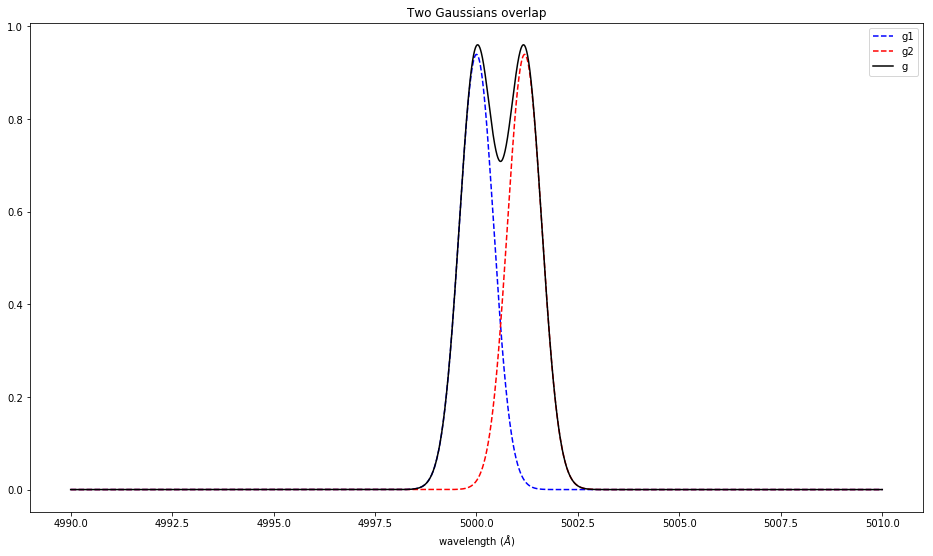

contrast: [0.15089458]


In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
def fct_Gauss(x,esp,sig):
    return (1/(np.sqrt(2*np.pi)*sig))*np.exp(-0.5*(x-esp)**2/sig**2)
R = 5000 # resolution
lam = 5000 # wavelength [Ångström]
dlam = lam/R
sig = dlam/np.sqrt(8*np.log(2))
esp1 = 5000
k = np.sqrt(-np.log(0.37703)*8) # From calculation on paper
distance = k*sig
esp2 = esp1 + distance
n = 10000
wavelength = np.linspace(4990,5010,n)
g1 = fct_Gauss(wavelength,esp1,sig)
g2 = fct_Gauss(wavelength,esp2,sig)
g = g1 + g2
plt.figure(figsize=[16,9])
plt.title('Two Gaussians overlap')
plt.plot(wavelength,g1,'--b',label='g1')
plt.plot(wavelength,g2,'--r',label='g2')
plt.plot(wavelength,g,'k',label='g')
plt.xlabel('wavelength ($\AA$)')
plt.legend()
plt.show()
x_min_loc = signal.argrelmin(g)[0]
f_min_loc = g[x_min_loc]
x_peak = signal.find_peaks(g)[0][0]
f_peak = g[x_peak]
C = (f_peak - f_min_loc)/(f_peak + f_min_loc)
print('contrast:', C)

In [6]:
# x_min_loc = signal.argrelmin(res_cste)[0]
# f_min_loc = res_cste[x_min_loc]
# x_peaks = signal.find_peaks(res_cste)[0][0]
# f_peaks = res_cste[x_peaks]
# contrast = (f_peaks - f_min_loc) / (f_peaks + f_min_loc)

In [ ]:
  
    
f_spectrum_w = interpolate.interp1d(Wlength, Spectrum, kind = 'cubic')
f_Resolution_w = interpolate.interp1d(Wlength, Resolution_limit, kind = 'cubic')
#Wlength_new =  linspace(Wlength[0],Wlength[N-1],N*ratio)
Wlength_new = []
for i in range(len(Wlength)-1):
    Wlength_new.extend(linspace(Wlength[i],Wlength[i+1],max(Resolution_limit)/Resolution_limit[i]))
Spectrum_wn = f_spectrum_w(Wlength_new);
Resolution_wn = f_Resolution_w(Wlength_new);
#plt.figure()
#plt.plot(Wlength*1e9,Spectrum,'+')
#plt.plot(Wlength_new*1e9,interpolate.splev(Wlength_new, Spline_Spectrum, der=0),'+')
sigma = max(Resolution_limit)/2.35482;
gauss = 1/(sigma*sqrt(2*pi))*exp(-0.5*((Wlength_new-Wlength_new[int(len(Wlength_new)/2)])/sigma)**2)
#plt.figure()
#plt.plot(Wlength_new,gauss)
convolution_data = convolve(Spectrum_wn,gauss,'same')
plt.figure()
plt.plot(Wlength,Spectrum)
plt.plot(Wlength_new,convolution_data/1e9)
    
